## code for back-extracting a timeseries of co2 flux from hindcast201905
## comparison of back-extracted flux from hindcast 2015 to model-output extracted flux from BR3-2015

### Summary:

- as written right now, backcalculated and model-output air-sea flux is *not directly comparable*
- the backcalculation dramatically increases air-sea flux; this may be due to slightly different parameterization - did not do a thorough analysis
- used the same pco2 flux module from matlab that I helped Jurleys with a few months ago; didn't translate mocsy's pco2 flux from fortran
- year 2015 outgassed less than any other year, from a quick analysis; pattern is robust



In [185]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [186]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [187]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [188]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt
import pickle

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

#import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
#from matplotlib import reload
import arrow
import gsw
%matplotlib inline

import xarray as xr
from datetime import datetime
from salishsea_tools import grid_tools, viz_tools

from math import log10, floor
import pytz

## TJŠJ translation of quick co2 flux matlab script
#### https://www.mathworks.com/matlabcentral/fileexchange/50190-air-sea-co2-flux
#### NOT identical to mocsy parameterization > did only limited delving to find out where they are different


- this has two modes - wind < 6 m/s, wind > 6 m/s
- subdivided as FCO2_lowwind and FCO2_highwind


In [189]:
def FCO2(pCO2_agua, pCO2_atm,T,S,u):
   
    ##Function for the calculation or air-sea CO2 flux
        #   copyright @ 2015 Cecilia Chapa-Balcorta

        #INPUT
    
   #pCO2_agua= seawater pCO2 (uatm)
   #pCO2_atm=  atmospheric pCO2 (uatm)
   #T=  Temperature (Celsius)
   #S=  Salinity 
   #u = Wind speed (m/s)

   #Air-sea CO2 is calculated as follows:
   
           # FCO2 =K*a(dpCO2) 
    
    #Where
    #K=is the transfer velocity according to Wanninkhof (1992).
    #a = CO2 solibility constant according to Weiss (1974)
    #dpCO2 is the difference of air and seawater pCO2 
    
    
    ##### CO2 Transfer velocity calculation #########
       
    Sc=Schmidt(T);
    if u<=6:
        K=0.31*(u**2)*((Sc/660)**-0.5); #for slower steadier wind
    #K=K*3600*24;  #conversion to   m/day
    else:    
        K=0.39*(u**2)*((Sc/660)**-0.5);


    dpCO2=pCO2_agua-pCO2_atm;     ##calculation of delta pCO2
    a=Ko_weiss(T,S);    #Solibility in mmol L^-1 atm^-1 or mmol m^-3 uatm^-1
    
    F_CO2 =0.24*K*a*dpCO2; #CO2 flux (mmol m^-2 d^-1)
    
    return  F_CO2, dpCO2

#####Subrutines #################################################

#****Solibuility constant (Weiss, 1974) ***********************************

def Ko_weiss(T,S):
#
    A=[-60.2409, 93.4517, 23.3585];  #mol/Kg.atm
    B=[0.023517, -0.023656, 0.0047036]; #mol/Kg.atm
    T=T+273.15; #Conversio from Celsius degrees to Kelvins
    Ln_Ko=A[0]+(A[1]*(100/T))+(A[2]*np.log(T/100))+S*(B[0]+(B[1]*(T/100))+(B[2]*(T/100)**2));
    Ko=np.exp(Ln_Ko);

    return Ko

#******** Schmidt Number*********

    #For water of salinity=35 and temperature range 0-30∞C    #############

def Schmidt(T):
    
    A = 2073.1;     B = 125.62;     C = 3.6276;     D = 0.043219;
    Sc= A - (B*T)+(C*T**2)-(D*T**3);
    
    return Sc
    


def FCO2_lowwind(pCO2_agua, pCO2_atm,T,S,u):
   
    ##Function for the calculation or air-sea CO2 flux
        #same as above, but only u<6
    
    ##### CO2 Transfer velocity calculation #########
       
    Sc=Schmidt(T);
    #assumption, u <6
    K=0.31*(u**2)*((Sc/660)**-0.5); #for slower steadier wind 
    #K=K*3600*24;  #conversion to   m/day
    #else:    

    dpCO2=pCO2_agua-pCO2_atm;     ##calculation of delta pCO2
    a=Ko_weiss(T,S);    #Solibility in mmol L^-1 atm^-1 or mmol m^-3 uatm^-1
    
    F_CO2 =0.24*K*a*dpCO2; #CO2 flux (mmol m^-2 d^-1)
    
    return  F_CO2, dpCO2

def FCO2_highwind(pCO2_agua, pCO2_atm,T,S,u):
   
    ##Function for the calculation or air-sea CO2 flux
        #same as above, but only u<6
    
    ##### CO2 Transfer velocity calculation #########
       
    Sc=Schmidt(T);
    #assumption, u >=6
    K=0.39*(u**2)*((Sc/660)**-0.5); #for slower steadier wind
    #K=K*3600*24;  #conversion to   m/day
    #else:    

    dpCO2=pCO2_agua-pCO2_atm;     ##calculation of delta pCO2
    a=Ko_weiss(T,S);    #Solibility in mmol L^-1 atm^-1 or mmol m^-3 uatm^-1
    
    F_CO2 =0.24*K*a*dpCO2; #CO2 flux (mmol m^-2 d^-1)
    
    return  F_CO2, dpCO2



## find and plot atmospheric pCO2 vs time for 2008-2015 (to put into co2 flux calculation)

In [190]:
start ='2008-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)


arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

dayslen = len(arrow_array)
atcco2_array = np.zeros(dayslen)
dec_time_array = np.zeros(dayslen)


#constants from SKOG

LR_slope   =  2.149     #  linear regression + gaussian fit
LR_int     =  -3929.359 #  to seasonal cycle of atmospheric co2
ctr        =  161.898   #  based on scripps observations at ptbarrow and lajolla
amp        =  7.083     #  calc notebook by TJSJ
wid        =  44.703    #  notebook loc:
ctr2       =  218.832   #  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #
wid2       =  87.8836   #
ctr3       =  199.430   #
amp3       =  8.026     #
wid3       =  -185.920  #

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)

Text(0, 0.5, 'uatm co2 ')

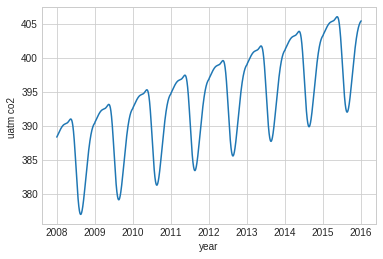

In [191]:
plt.plot(dec_time_array,atcco2_array)
plt.xlabel('year')
plt.ylabel('uatm co2 ')


## using this alg to calculate air-sea flux for day 20150201  from hindcast, also extract model-calculated co2 flux for the same day (for BR3) and compare. Then look at differences between carbon content for the two model days - it's small

- we see that the backcalculated estimate results in far larger outgassing - flux, in any direction, is larger

## code to get daily co2 flux fields for hindcast using translated fco2.m, 2008-2015 (currently commented out)

In [192]:
# start_run = arrow.get(start)
# end_run = arrow.get(end)


# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')



#     if i%50 == 0:
#         print(ymd)
#     t_grid = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/grid_1d_'+ymd+'.nc')
#     t_pco2 = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/OmA_plus_'+ymd+'.nc')
#     t_wind = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    
#     temp = np.ravel(t_grid['model_output']['TEMP'][0,:,:])
#     sal = np.ravel(t_grid['model_output']['SAL'][0,:,:])
#     pco2 = np.ravel(t_pco2['model_output']['pCO2'][:,:])
#     wind = np.ravel(t_wind['model_output']['wind_mag'][:,:])
#     tzero = np.zeros_like(wind)
#     pCO2_atm = np.zeros_like(wind)
#     pCO2_atm[:] = atcco2_array[i]
#     #2 algs for calculating fco2, high and low
#     F_CO2_high_alg = np.zeros_like(wind)
#     F_CO2_low_alg = np.zeros_like(wind)
#     F_CO2 = np.zeros_like(wind)
    
#     tsra_psu = sal*35/35.16504
#     ttera_is = gsw.t_from_CT(sal,temp,tzero)
    
#     F_CO2_high_alg, dpCO2 =  FCO2_highwind(pco2, pCO2_atm,temp,sal,wind)
#     F_CO2_low_alg, dpCO2 =  FCO2_lowwind(pco2, pCO2_atm,temp,sal,wind)
    
#     lowwind = np.where(wind<6)
#     land = np.where(np.ma.is_masked(temp))
    
#     F_CO2_high_alg[lowwind] = F_CO2_low_alg[lowwind]
#     #F_CO2_high_alg[land] = np.nan
    
#     F_CO2_high_alg_r = F_CO2_high_alg.reshape(898,398)
#     F_CO2_high_alg_r[F_CO2_high_alg_r>1e5] = np.nan
#     F_CO2_high_alg_out_neg = -1*F_CO2_high_alg_r
    
#     fn = 'co2flux' + ymd + '.nc'
#     tdir = '/data/tjarniko/results/hindcast.201905_co2flux/'
#     ncname = tdir + fn

#     f = nc.Dataset(ncname,'w', format='NETCDF4') #'w' stands for write
#     g = f.createGroup('model_output')
#     g.createDimension('ydir',898)
#     g.createDimension('xdir',398)

#     ts = g.createVariable('CO2flux_mmol_m2_day','f4',('ydir','xdir'))
#     ts[:] = F_CO2_high_alg_out_neg[:,:]


## code to get timeseries of air-sea mean fluxes (commented out)

In [193]:
# start_run = arrow.get('2008-01-01')
# end_run = arrow.get('2008-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)
# print(dayslen)

# if len(arrow_array) == 366:
#     arrow_array.pop(59)
    
# dayslen = len(arrow_array)
# print(dayslen)
    
# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2008_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2009-01-01')
# end_run = arrow.get('2009-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2009_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2010-01-01')
# end_run = arrow.get('2010-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2010_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2011-01-01')
# end_run = arrow.get('2011-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2011_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2012-01-01')
# end_run = arrow.get('2012-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# dayslen = len(arrow_array)
# print(dayslen)

# if len(arrow_array) == 366:
#     arrow_array.pop(59)
    
# dayslen = len(arrow_array)
# print(dayslen)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2012_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2013-01-01')
# end_run = arrow.get('2013-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2013_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2014-01-01')
# end_run = arrow.get('2014-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2014_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2015-01-01')
# end_run = arrow.get('2015-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2015_co2_flx.pkl", 'wb'))

## code to get timeseries of mean windspeeds (commented out)

In [194]:
# start_run = arrow.get('2008-01-01')
# end_run = arrow.get('2008-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)
# print(dayslen)

# if len(arrow_array) == 366:
#     arrow_array.pop(59)
    
# dayslen = len(arrow_array)
# print(dayslen)
    
# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2008_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2009-01-01')
# end_run = arrow.get('2009-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2009_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2010-01-01')
# end_run = arrow.get('2010-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2010_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2011-01-01')
# end_run = arrow.get('2011-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2011_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2012-01-01')
# end_run = arrow.get('2012-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# dayslen = len(arrow_array)
# print(dayslen)

# if len(arrow_array) == 366:
#     arrow_array.pop(59)
    
# dayslen = len(arrow_array)
# print(dayslen)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2012_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2013-01-01')
# end_run = arrow.get('2013-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2013_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2014-01-01')
# end_run = arrow.get('2014-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2014_wind_mag.pkl", 'wb'))

# start_run = arrow.get('2015-01-01')
# end_run = arrow.get('2015-12-31')

# wind_mag = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
#     wind_mag[i] = np.nanmean(t_flx['model_output']['wind_mag'][:])
    
# pickle.dump(wind_mag, open("hindcast2015_wind_mag.pkl", 'wb'))

## extract BR3 air-sea flux (in situ); commented out

In [195]:
# start = '2015-01-01'
# end = '2015-12-31'
# start_run = arrow.get(start)
# end_run = arrow.get(end)

# mean_br3_asflux = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     if i%50 == 0:
#         print(ymd)
#     tnc = glob.glob('/data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/'\
#                         'SKOG*carp*'+ymd+'*.nc')
#     t_carp = nc.Dataset(tnc[0])
#     co2 = t_carp['co2_flux_mmol_m2_s'][0,:,:]
#     ## mean 
#     co2_mean_mmol_m2_day = np.nanmean(co2) * 86400
#     mean_br3_asflux[i] = co2_mean_mmol_m2_day
    
# pickle.dump(mean_br3_asflux, open("./pkls_hindcast201905_airseaflux/BR3_2015_co2_flx.pkl", 'wb'))

Text(0.5, 0, 'days')

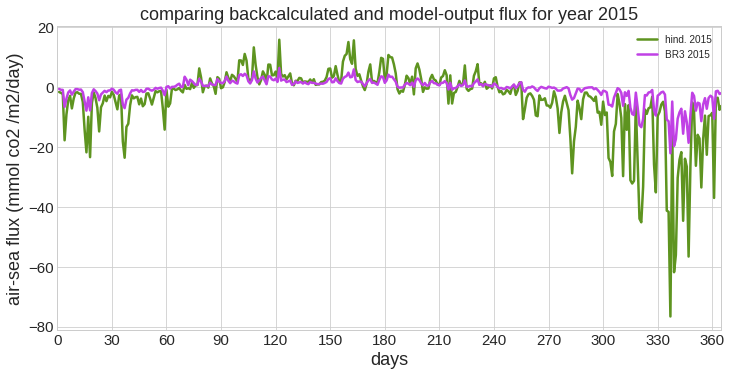

In [196]:
BR3_2015_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/BR3_2015_co2_flx.pkl', 'rb'))  
hindcast2008_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2008_co2_flx.pkl', 'rb'))  
hindcast2009_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2009_co2_flx.pkl', 'rb'))  
hindcast2010_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2010_co2_flx.pkl', 'rb'))  
hindcast2011_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2011_co2_flx.pkl', 'rb'))  
hindcast2012_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2012_co2_flx.pkl', 'rb'))  
hindcast2013_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2013_co2_flx.pkl', 'rb'))  
hindcast2014_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2014_co2_flx.pkl', 'rb'))  
hindcast2015_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2015_co2_flx.pkl', 'rb'))

hindcast2008_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2008_wind_mag.pkl', 'rb'))  
hindcast2009_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2009_wind_mag.pkl', 'rb'))  
hindcast2010_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2010_wind_mag.pkl', 'rb'))  
hindcast2011_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2011_wind_mag.pkl', 'rb'))  
hindcast2012_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2012_wind_mag.pkl', 'rb'))  
hindcast2013_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2013_wind_mag.pkl', 'rb'))  
hindcast2014_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2014_wind_mag.pkl', 'rb'))  
hindcast2015_wind_mag = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2015_wind_mag.pkl', 'rb'))  


days = np.arange(1,366,1)
tcm = cm.cm.phase

fs = 18
fact = 0.7
fig = plt.figure(figsize=(17*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)

#months

ax1.plot(days,hindcast2015_co2_flx, \
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = 'hind. 2015')
ax1.plot(days,BR3_2015_co2_flx, \
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = 'BR3 2015')




ax1.tick_params(axis='both', which='major', labelsize=15)
#ax1.legend(bbox_to_anchor=[1, 1], fontsize = fs-4.5)
ax1.legend(loc = 'best')
w = ax1.set_xticks(np.arange(0, 365, step=30))
ax1.set_xlim(0,365)
#w = ax1.set_yticks(np.arange(0, 110, step=10))
ax1.set_ylabel('air-sea flux (mmol co2 /m2/day)', fontsize = 18)
ax1.set_title('comparing backcalculated and model-output flux for year 2015', fontsize = 18)
ax1.set_xlabel('days', fontsize = 18)

## visualizing an 8-year timeseries of mean air-sea fluxes and 'episodicity' of fluxes

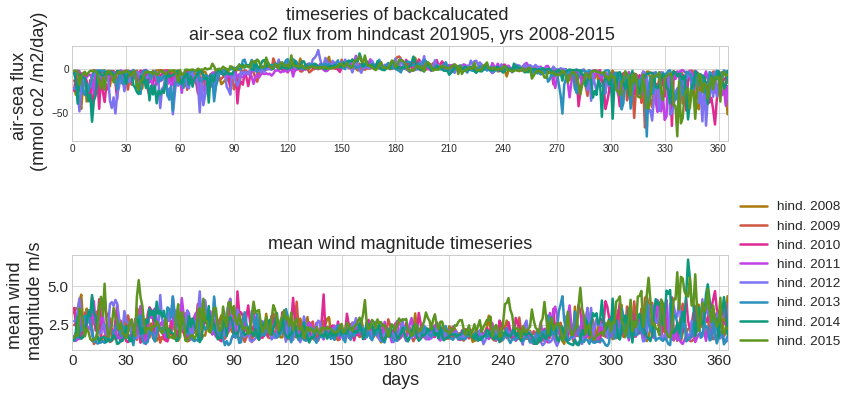

In [197]:


days = np.arange(1,366,1)
tcm = cm.cm.phase

fs = 18
fact = 0.7
fig = plt.figure(figsize=(17*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(2,1,1)

#months
ax1.plot(days,hindcast2008_co2_flx, \
         color = tcm(1.*0/8),linewidth = lw, linestyle = '-', label = 'hind. 2008')
ax1.plot(days,hindcast2009_co2_flx, \
         color = tcm(1.*1/8),linewidth = lw, linestyle = '-', label = 'hind. 2009')
ax1.plot(days,hindcast2010_co2_flx, \
         color = tcm(1.*2/8),linewidth = lw, linestyle = '-', label = 'hind. 2010')
ax1.plot(days,hindcast2011_co2_flx, \
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = 'hind. 2011')
ax1.plot(days,hindcast2012_co2_flx, \
         color = tcm(1.*4/8),linewidth = lw, linestyle = '-', label = 'hind. 2012')
ax1.plot(days,hindcast2013_co2_flx, \
         color = tcm(1.*5/8),linewidth = lw, linestyle = '-', label = 'hind. 2013')
ax1.plot(days,hindcast2014_co2_flx, \
         color = tcm(1.*6/8),linewidth = lw, linestyle = '-', label = 'hind. 2014')
ax1.plot(days,hindcast2015_co2_flx, \
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = 'hind. 2015')

ax1.set_ylabel('air-sea flux \n (mmol co2 /m2/day)', fontsize = 18)
ax1.set_title('timeseries of backcalucated \n air-sea co2 flux from hindcast 201905, yrs 2008-2015', fontsize = 18)
ax1.set_xlim(0,365)
w = ax1.set_xticks(np.arange(0, 365, step=30))

ax1 = fig.add_subplot(2,1,2)


#months
ax1.plot(days,hindcast2008_wind_mag, \
         color = tcm(1.*0/8),linewidth = lw, linestyle = '-', label = 'hind. 2008')
ax1.plot(days,hindcast2009_wind_mag, \
         color = tcm(1.*1/8),linewidth = lw, linestyle = '-', label = 'hind. 2009')
ax1.plot(days,hindcast2010_wind_mag, \
         color = tcm(1.*2/8),linewidth = lw, linestyle = '-', label = 'hind. 2010')
ax1.plot(days,hindcast2011_wind_mag, \
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = 'hind. 2011')
ax1.plot(days,hindcast2012_wind_mag, \
         color = tcm(1.*4/8),linewidth = lw, linestyle = '-', label = 'hind. 2012')
ax1.plot(days,hindcast2013_wind_mag, \
         color = tcm(1.*5/8),linewidth = lw, linestyle = '-', label = 'hind. 2013')
ax1.plot(days,hindcast2014_wind_mag, \
         color = tcm(1.*6/8),linewidth = lw, linestyle = '-', label = 'hind. 2014')
ax1.plot(days,hindcast2015_wind_mag, \
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = 'hind. 2015')

ax1.set_ylabel('mean wind \n magnitude m/s', fontsize = 18)
ax1.set_title('mean wind magnitude timeseries', fontsize = 18)



ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.legend(bbox_to_anchor=[1, 1.7], fontsize = fs-4.5)
#ax1.legend(loc = 'best')
w = ax1.set_xticks(np.arange(0, 365, step=30))
ax1.set_xlim(0,365)
#w = ax1.set_yticks(np.arange(0, 110, step=10))
ax1.set_xlabel('days', fontsize = 18)
plt.tight_layout()

In [198]:
pos2008 = np.sort(hindcast2008_co2_flx[hindcast2008_co2_flx>0])[::-1]
neg2008 = np.sort(-1*hindcast2008_co2_flx[hindcast2008_co2_flx<0])[::-1]
pos2009 = np.sort(hindcast2009_co2_flx[hindcast2009_co2_flx>0])[::-1]
neg2009 = np.sort(-1*hindcast2009_co2_flx[hindcast2009_co2_flx<0])[::-1]
pos2010 = np.sort(hindcast2010_co2_flx[hindcast2010_co2_flx>0])[::-1]
neg2010 = np.sort(-1*hindcast2010_co2_flx[hindcast2010_co2_flx<0])[::-1]
pos2011 = np.sort(hindcast2011_co2_flx[hindcast2011_co2_flx>0])[::-1]
neg2011 = np.sort(-1*hindcast2011_co2_flx[hindcast2011_co2_flx<0])[::-1]
pos2012 = np.sort(hindcast2012_co2_flx[hindcast2012_co2_flx>0])[::-1]
neg2012 = np.sort(-1*hindcast2012_co2_flx[hindcast2012_co2_flx<0])[::-1]
pos2013 = np.sort(hindcast2013_co2_flx[hindcast2013_co2_flx>0])[::-1]
neg2013 = np.sort(-1*hindcast2013_co2_flx[hindcast2013_co2_flx<0])[::-1]
pos2014 = np.sort(hindcast2014_co2_flx[hindcast2014_co2_flx>0])[::-1]
neg2014 = np.sort(-1*hindcast2014_co2_flx[hindcast2014_co2_flx<0])[::-1]
pos2015 = np.sort(hindcast2015_co2_flx[hindcast2015_co2_flx>0])[::-1]
neg2015 = np.sort(-1*hindcast2015_co2_flx[hindcast2015_co2_flx<0])[::-1]

pos_prop_2008 = np.zeros(365); neg_prop_2008 = np.zeros(365);
pos_prop_2009 = np.zeros(365); neg_prop_2009 = np.zeros(365); 
pos_prop_2010 = np.zeros(365); neg_prop_2010 = np.zeros(365);
pos_prop_2011 = np.zeros(365); neg_prop_2011 = np.zeros(365) ;
pos_prop_2012 = np.zeros(365); neg_prop_2012 = np.zeros(365)
pos_prop_2013 = np.zeros(365); neg_prop_2013 = np.zeros(365)
pos_prop_2014 = np.zeros(365); neg_prop_2014 = np.zeros(365)
pos_prop_2015 = np.zeros(365); neg_prop_2015 = np.zeros(365)

for i in range(0,365):
    pos_prop_2008[i] = np.sum(pos2008[0:i+1])/np.sum(pos2008)
    neg_prop_2008[i] = np.sum(neg2008[0:i+1])/np.sum(neg2008)
    pos_prop_2009[i] = np.sum(pos2009[0:i+1])/np.sum(pos2009)
    neg_prop_2009[i] = np.sum(neg2009[0:i+1])/np.sum(neg2009)    
    pos_prop_2010[i] = np.sum(pos2010[0:i+1])/np.sum(pos2010)
    neg_prop_2010[i] = np.sum(neg2010[0:i+1])/np.sum(neg2010)
    pos_prop_2011[i] = np.sum(pos2011[0:i+1])/np.sum(pos2011)
    neg_prop_2011[i] = np.sum(neg2011[0:i+1])/np.sum(neg2011)
    pos_prop_2012[i] = np.sum(pos2012[0:i+1])/np.sum(pos2012)
    neg_prop_2012[i] = np.sum(neg2012[0:i+1])/np.sum(neg2012)
    pos_prop_2013[i] = np.sum(pos2013[0:i+1])/np.sum(pos2013)
    neg_prop_2013[i] = np.sum(neg2013[0:i+1])/np.sum(neg2013)
    pos_prop_2014[i] = np.sum(pos2014[0:i+1])/np.sum(pos2014)
    neg_prop_2014[i] = np.sum(neg2014[0:i+1])/np.sum(neg2014)
    pos_prop_2015[i] = np.sum(pos2015[0:i+1])/np.sum(pos2015)
    neg_prop_2015[i] = np.sum(neg2015[0:i+1])/np.sum(neg2015)

Text(0.5, 1.0, 'Sum of top x days as proportion of total system \n outgassing (dashed) or ingassing (solid)')

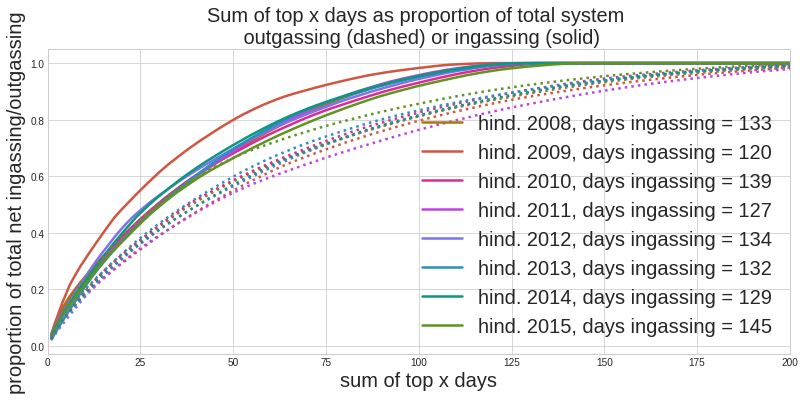

In [199]:
fs = 18
fact = 0.7
fig = plt.figure(figsize=(19*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)

#months
ax1.plot(days,pos_prop_2008, color = tcm(1.*0/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2008, days ingassing = '+ str(np.size(pos2008)))
ax1.plot(days,pos_prop_2009, color = tcm(1.*1/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2009, days ingassing = '+ str(np.size(pos2009)))
ax1.plot(days,pos_prop_2010, color = tcm(1.*2/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2010, days ingassing = '+ str(np.size(pos2010)))
ax1.plot(days,pos_prop_2011, color = tcm(1.*3/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2011, days ingassing = '+ str(np.size(pos2011)))
ax1.plot(days,pos_prop_2012,  color = tcm(1.*4/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2012, days ingassing = '+ str(np.size(pos2012)))
ax1.plot(days,pos_prop_2013, color = tcm(1.*5/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2013, days ingassing = '+ str(np.size(pos2013)))
ax1.plot(days,pos_prop_2014, color = tcm(1.*6/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2014, days ingassing = '+ str(np.size(pos2014)))
ax1.plot(days,pos_prop_2015, color = tcm(1.*7/8),linewidth = lw, \
         linestyle = '-', label = 'hind. 2015, days ingassing = '+ str(np.size(pos2015)))

ax1.plot(days,neg_prop_2008, color = tcm(1.*0/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2009, color = tcm(1.*1/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2010, color = tcm(1.*2/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2011, color = tcm(1.*3/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2012,  color = tcm(1.*4/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2013, color = tcm(1.*5/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2014, color = tcm(1.*6/8),linewidth = lw, \
         linestyle = ':')
ax1.plot(days,neg_prop_2015, color = tcm(1.*7/8),linewidth = lw, \
         linestyle = ':')

ax1.legend(loc = 'best', fontsize = 20)
ax1.set_xlim(0,200)
ax1.set_xlabel('sum of top x days', fontsize = 20)
ax1.set_ylabel('proportion of total net ingassing/outgassing', fontsize = 20)
ax1.set_title\
('Sum of top x days as proportion of total system \n outgassing (dashed) or ingassing (solid)', fontsize = 20)

In [200]:
# fs = 18
# fact = 0.7
# fig = plt.figure(figsize=(17*fact,8*fact))
# lw = 2.5
# ax1 = fig.add_subplot(1,1,1)

# #months
# ax1.plot(days,neg_prop_2008, color = tcm(1.*0/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2008, days outgassing = '+ str(np.size(neg2008)))
# ax1.plot(days,neg_prop_2009, color = tcm(1.*1/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2009, days outgassing = '+ str(np.size(neg2009)))
# ax1.plot(days,neg_prop_2010, color = tcm(1.*2/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2010, days outgassing = '+ str(np.size(neg2010)))
# ax1.plot(days,neg_prop_2011, color = tcm(1.*3/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2011, days outgassing = '+ str(np.size(neg2011)))
# ax1.plot(days,neg_prop_2012,  color = tcm(1.*4/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2012, days outgassing = '+ str(np.size(neg2012)))
# ax1.plot(days,neg_prop_2013, color = tcm(1.*5/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2013, days outgassing = '+ str(np.size(neg2013)))
# ax1.plot(days,neg_prop_2014, color = tcm(1.*6/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2014, days outgassing = '+ str(np.size(neg2014)))
# ax1.plot(days,neg_prop_2015, color = tcm(1.*7/8),linewidth = lw, \
#          linestyle = '-', label = 'hind. 2015, days outgassing = '+ str(np.size(neg2015)))


# ax1.legend(loc = 'best', fontsize = 20)
# ax1.set_xlim(0,245)
# ax1.set_xlabel('sum of top x days', fontsize = 20)
# ax1.set_ylabel('proportion of total net outgassing', fontsize = 20)

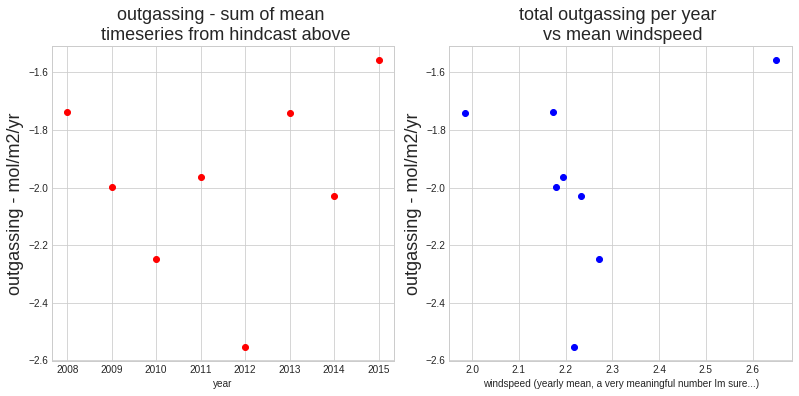

In [201]:
hind08_co2_flx_yr = np.sum(hindcast2008_co2_flx)/1000
hind09_co2_flx_yr = np.sum(hindcast2009_co2_flx)/1000
hind10_co2_flx_yr = np.sum(hindcast2010_co2_flx)/1000
hind11_co2_flx_yr = np.sum(hindcast2011_co2_flx)/1000
hind12_co2_flx_yr = np.sum(hindcast2012_co2_flx)/1000
hind13_co2_flx_yr = np.sum(hindcast2013_co2_flx)/1000
hind14_co2_flx_yr = np.sum(hindcast2014_co2_flx)/1000
hind15_co2_flx_yr = np.sum(hindcast2015_co2_flx)/1000

hind08_wind_mag_yr = np.nanmean(hindcast2008_wind_mag)
hind09_wind_mag_yr = np.nanmean(hindcast2009_wind_mag)
hind10_wind_mag_yr = np.nanmean(hindcast2010_wind_mag)
hind11_wind_mag_yr = np.nanmean(hindcast2011_wind_mag)
hind12_wind_mag_yr = np.nanmean(hindcast2012_wind_mag)
hind13_wind_mag_yr = np.nanmean(hindcast2013_wind_mag)
hind14_wind_mag_yr = np.nanmean(hindcast2014_wind_mag)
hind15_wind_mag_yr = np.nanmean(hindcast2015_wind_mag)

yrs = np.arange(2008,2016,1)
hindsums = [hind08_co2_flx_yr,hind09_co2_flx_yr,hind10_co2_flx_yr,hind11_co2_flx_yr,hind12_co2_flx_yr,\
            hind13_co2_flx_yr,hind14_co2_flx_yr,hind15_co2_flx_yr]

hind_windmeans = [hind08_wind_mag_yr,hind09_wind_mag_yr,hind10_wind_mag_yr,hind11_wind_mag_yr,hind12_wind_mag_yr,\
            hind13_wind_mag_yr,hind14_wind_mag_yr,hind15_wind_mag_yr]

hindcast2008_co2_flx

days = np.arange(1,366,1)
tcm = cm.cm.phase

fs = 18
fact = 0.7
fig = plt.figure(figsize=(16*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(1,2,1)

#months

ax1.plot(yrs,hindsums,'ro')
# ax1.plot(yrs,hind_windmeans,'bo')

ax1.set_title('outgassing - sum of mean \n timeseries from hindcast above', fontsize = 18)
ax1.set_ylabel('outgassing - mol/m2/yr', fontsize = 18)
ax1.set_xlabel('year')

ax1 = fig.add_subplot(1,2,2)

#months

ax1.plot(hind_windmeans,hindsums,'bo')
# ax1.plot(yrs,hind_windmeans,'bo')

ax1.set_title('total outgassing per year \n vs mean windspeed', fontsize = 18)
ax1.set_ylabel('outgassing - mol/m2/yr', fontsize = 18)
ax1.set_xlabel('windspeed (yearly mean, a very meaningful number Im sure...)')

plt.tight_layout()

In [202]:
#np.max(hindcast2015_co2_flx) #22

step = 5
t_start = -80
t_end = 30
bin_starts = np.arange(t_start,t_end,step)
bin_ends = np.arange(t_start+step,t_end+step,step)

bin_centres = np.arange(t_start+step/2,t_end + step/2 ,step)

def manual_hist(test_hist):
    bin_prop = np.zeros_like(bin_starts)
    bin_prop = bin_prop.astype(float)
    for i in range(0,len(bin_starts)):
        #print(i)
        obs_in_bin = test_hist[((test_hist>=bin_starts[i]) &\
                               (test_hist<bin_ends[i]))]
        #print(obs_in_bin)
        #print(np.size(obs_in_bin)/np.size(test_hist))
        bin_prop[i] = np.size(obs_in_bin)/np.size(test_hist)
        #print(bin_prop[i])
    return bin_prop
        
bin_prop_co2flx_2008 = manual_hist(hindcast2008_co2_flx)
bin_prop_co2flx_2009 = manual_hist(hindcast2009_co2_flx)
bin_prop_co2flx_2010 = manual_hist(hindcast2010_co2_flx)
bin_prop_co2flx_2011 = manual_hist(hindcast2011_co2_flx)
bin_prop_co2flx_2012 = manual_hist(hindcast2012_co2_flx)
bin_prop_co2flx_2013 = manual_hist(hindcast2013_co2_flx)
bin_prop_co2flx_2014 = manual_hist(hindcast2014_co2_flx)
bin_prop_co2flx_2015 = manual_hist(hindcast2015_co2_flx)

step = 0.2
t_start = 0
t_end = 10
bin_starts = np.arange(t_start,t_end,step)
bin_ends = np.arange(t_start+step,t_end+step,step)

bin_centres2 = np.arange(t_start+step/2,t_end + step/2 ,step)

bin_prop_windmag_2008 = manual_hist(hindcast2008_wind_mag)
bin_prop_windmag_2009 = manual_hist(hindcast2009_wind_mag)
bin_prop_windmag_2010 = manual_hist(hindcast2010_wind_mag)
bin_prop_windmag_2011 = manual_hist(hindcast2011_wind_mag)
bin_prop_windmag_2012 = manual_hist(hindcast2012_wind_mag)
bin_prop_windmag_2013 = manual_hist(hindcast2013_wind_mag)
bin_prop_windmag_2014 = manual_hist(hindcast2014_wind_mag)
bin_prop_windmag_2015 = manual_hist(hindcast2015_wind_mag)

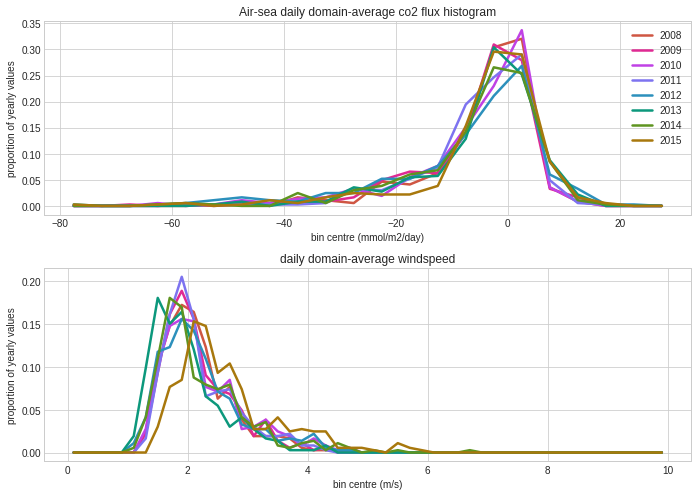

In [203]:
tcm = cm.cm.phase
# d = 
# # tcm(1.*d/12)
fs = 18
fact = 0.7
fig = plt.figure(figsize=(14*fact,10*fact))
lw = 2.5

ax1 = fig.add_subplot(2,1,1)
#months
ax1.plot(bin_centres,bin_prop_co2flx_2008,\
         color = tcm(1.*1/8),linewidth = lw, linestyle = '-', label = '2008')
ax1.plot(bin_centres,bin_prop_co2flx_2009,\
         color = tcm(1.*2/8),linewidth = lw, linestyle = '-', label = '2009')
ax1.plot(bin_centres,bin_prop_co2flx_2010,\
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = '2010')
ax1.plot(bin_centres,bin_prop_co2flx_2011,\
         color = tcm(1.*4/8),linewidth = lw, linestyle = '-', label = '2011')
ax1.plot(bin_centres,bin_prop_co2flx_2012,\
         color = tcm(1.*5/8),linewidth = lw, linestyle = '-', label = '2012')
ax1.plot(bin_centres,bin_prop_co2flx_2013,\
         color = tcm(1.*6/8),linewidth = lw, linestyle = '-', label = '2013')
ax1.plot(bin_centres,bin_prop_co2flx_2014,\
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = '2014')
ax1.plot(bin_centres,bin_prop_co2flx_2015,\
         color = tcm(1.*8/8),linewidth = lw, linestyle = '-', label = '2015')
ax1.legend(loc='best')
ax1.set_xlabel('bin centre (mmol/m2/day)')
ax1.set_ylabel('proportion of yearly values')
ax1.set_title('Air-sea daily domain-average co2 flux histogram')
ax1 = fig.add_subplot(2,1,2)
#months
ax1.plot(bin_centres2,bin_prop_windmag_2008,\
         color = tcm(1.*1/8),linewidth = lw, linestyle = '-', label = '2008')
ax1.plot(bin_centres2,bin_prop_windmag_2009,\
         color = tcm(1.*2/8),linewidth = lw, linestyle = '-', label = '2009')
ax1.plot(bin_centres2,bin_prop_windmag_2010,\
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = '2010')
ax1.plot(bin_centres2,bin_prop_windmag_2011,\
         color = tcm(1.*4/8),linewidth = lw, linestyle = '-', label = '2011')
ax1.plot(bin_centres2,bin_prop_windmag_2012,\
         color = tcm(1.*5/8),linewidth = lw, linestyle = '-', label = '2012')
ax1.plot(bin_centres2,bin_prop_windmag_2013,\
         color = tcm(1.*6/8),linewidth = lw, linestyle = '-', label = '2013')
ax1.plot(bin_centres2,bin_prop_windmag_2014,\
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = '2014')
ax1.plot(bin_centres2,bin_prop_windmag_2015,\
         color = tcm(1.*8/8),linewidth = lw, linestyle = '-', label = '2015')
ax1.set_xlabel('bin centre (m/s)')
ax1.set_ylabel('proportion of yearly values')
ax1.set_title('daily domain-average windspeed')


plt.tight_layout()

In [204]:
print('done rendering notebook')

done rendering notebook
